In [1]:
import os
import pickle

import numpy as np
import pandas as pd

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image as kimage

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Small Network From Scratch

TODO:


# Pre-trained Model
Following the tutorial from: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html and
https://blog.nycdatascience.com/student-works/deep-learning-meets-recommendation-systems/

## Load training and validation images

In [2]:
train_dir = "data/posters_split/train/"
validation_dir = "data/posters_split/validation/"

In [3]:
train_filenames = os.listdir(train_dir)
n_train = len(train_filenames)

validation_filenames = os.listdir(validation_dir)
n_validation = len(validation_filenames)

In [8]:
# Load train images in arrays
images=[None]*n_train
X=[None]*n_train

for i, train_filename in enumerate(train_filenames):
    images[i] = kimage.load_img(train_dir + train_filename, target_size=(224, 224))
    X[i] = kimage.img_to_array(images[i])
    X[i] = np.expand_dims(X[i], axis=0)
    X[i] = preprocess_input(X[i]).reshape(224,224,3)  

In [ ]:
# Load validation images in arrays
val_images=[None]*n_validation
val_X=[None]*n_validation

for i, validation_filename in enumerate(validation_filenames):
    val_images[i] = kimage.load_img(validation_dir + validation_filename, target_size=(224, 224))
    val_X[i] = kimage.img_to_array(val_images[i])
    val_X[i] = np.expand_dims(val_X[i], axis=0)
    val_X[i] = preprocess_input(val_X[i]).reshape(224,224,3)  

## Use pretrained CNN to extract bottleneck features

In [ ]:
# Get bottleneck features from pretrained VGG16 
pretrained_model = VGG16(include_top=False, weights='imagenet')

X = np.array(X)
val_X = np.array(val_X)
train_features = pretrained_model.predict(X)
val_features = pretrained_model.predict(val_X)

# Save bottleneck features
np.save(open('bottleneck_features_train.npy', 'w'), train_features)
# Save bottleneck features
np.save(open('bottleneck_features_validation.npy', 'w'), val_features)

In [7]:
X.shape

(9291, 1, 224, 224, 3)

In [2]:
# Load bottleneck features
train_features = np.load('features/bottleneck_features_train.npy')
val_features = np.load('features/bottleneck_features_validation.npy')

## Get genres for each of the movies from their filenames

In [4]:
genre_dict = pickle.load(open("data/genre_dict.pickle", 'rb'))

# Get movie information (including genre labels) for train and validation data from filenames
train_movie_names = os.listdir("data/posters_split/train/")
# Unique id for each movie
train_ids = [filename.split("-")[-1].split("_")[0] for filename in train_movie_names]
train_ids = [int(id) for id in train_ids]
# List of genre ids for each movie
train_genre_ids = [map(int, os.path.splitext(filename)[0].split("-")[-1].split("_")[1:]) for filename in train_movie_names]

val_movie_names = os.listdir("data/posters_split/validation/")
# Unique id for each movie
val_ids = [filename.split("-")[-1].split("_")[0] for filename in val_movie_names]
val_ids = [int(id) for id in val_ids]
# List of genre ids for each movie
val_genre_ids = [map(int, os.path.splitext(filename)[0].split("-")[-1].split("_")[1:]) for filename in val_movie_names]

## Create a dictionary of TMdb ids for train, test and validation datasets
We do this so that we have a reference table to ensure that we use the same movies for train, test and validation across all our classification tasks.

In [14]:
train_val_test_byid = {"train": train_ids, "test": test_ids, "validation": val_ids}

In [ ]:
pickle.dump(train_val_test_byid, open("train_val_test_byid.pkl", 'wb'))

## Create binary encoded response vectors for train and validation datasets
TODO: Probably want to save these dataframes so we don't do this over and over.

In [4]:
train_multilabels = pd.DataFrame(index=train_ids)

# multilabel binary encoding by genre
for genre_id, genre in genre_dict.items():
    train_multilabels[genre] = [int(int(genre_id) in genre_list) for genre_list in train_genre_ids]
    
val_multilabels = pd.DataFrame(index=val_ids)

# multilabel binary encoding by genre
for genre_id, genre in genre_dict.items():
    val_multilabels[genre] = [int(int(genre_id) in genre_list) for genre_list in val_genre_ids]

In [5]:
train_multilabels.head()

,War,Mystery,Music,Comedy,History,Western,Animation,Adventure,Drama,Fantasy,Crime,TV Movie,Documentary,Thriller,Science Fiction,Horror,Action,Romance,Family
3133,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
407448,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0
33875,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0
110354,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
51619,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


## Add a fully-connected layer on top and train on bottleneck features

In [11]:
# Train a small fully-connected model on the bottleneck features
model = Sequential()
model.add(Flatten(input_shape=train_features.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(train_multilabels.shape[1], activation='sigmoid'))

model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_features, train_multilabels.values,
          epochs=50,
          batch_size=16,
          validation_data=(val_features, val_multilabels.values),
          verbose=0)
model.save_weights('bottleneck_fc_model.h5')

## Evaluation of performance
TODO: S

In [12]:
# once training is complete, let's see how well we have done
score = model.evaluate(train_features, train_multilabels.values, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

score = model.evaluate(val_features, val_multilabels.values, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

('Train loss:', 0.20986080607201874)
('Train accuracy:', 0.89913258466842727)
('Validation loss:', 0.42673873963027165)
('Validation accuracy:', 0.86542637183748439)


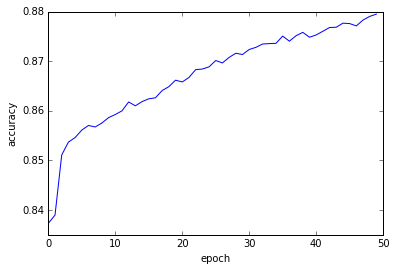

In [15]:
# here is a visualization of the training process
# typically we gain a lot in the beginning and then
# training slows down
plt.plot(history.history['acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")